
---

# ADL HW3 - Pretrained Models

In this assignment, you will analyze and compare a few pre-trained models from the field of computer vision.

The assignment is divided into several tasks:

- **EX1 - The Imagenette Dataset (10 pts)**  
- **EX2 - Pretrained Models (20 pts)**  
- **EX3 - Visualizing Feature Maps (30 pts)**  
- **EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50 pts)**  

Note: In this assignment, you will not train any models or aim to reach specific accuracy levels. Instead, you will investigate the behavior of a few pre-trained models.

---

## Grading

The grading for each section is indicated in the title. Grading will be based on the following criteria:

- **Following Instructions**  
- **Presentation**: Clear figures (with labels, titles, etc.), well-written discussions and comments, organized notebook, no leftover debugging prints, and no redundant functions.  
- **Clear and Efficient Code**: Your code should be clear and neat. Write clear comments and avoid `for loops` when vectorized operations are available. Use the GPU when possible.  
- **Discussion**: Ensure you write a discussion whenever it is required.  

---

## Submission Date: **31.01.2025**

Submit the fully executed notebook.

---


In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict, Counter
from torchsummary import summary
from sklearn.manifold import TSNE

# EX1 - Imagenette Dataset (10pts)



1.   Download the ```Imagenette``` dataset from ```torchvision``` ([link](https://pytorch.org/vision/0.19/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette)). Make sure the set size="160px" to avoid long downloading time.
2. Preprocess the data - resize to 256x256 and take a central crop of size 224. ToTensor, Normalize and so on.
3. Describe the dataset: number of samples for each set, classes labels, classes labels distribtuion (are they balanced?)

4. Plot 5 random samples from each class a present them in a ```num_classes X 5``` (rows X columns) grid.






In [ ]:
Imagenette_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Imagenette_data = datasets.Imagenette(root='./data', size = "160px", transform=Imagenette_transform, download=True)
Imagenette_data_train = datasets.Imagenette(root='./data', size="160px", transform=Imagenette_transform)

# Load validation data
Imagenette_data_val = datasets.Imagenette(root='./data', split='val', size="160px", transform=Imagenette_transform)

classes = Imagenette_data.classes
print(f"Total ImageNet classes: {len(classes)}")


100%|██████████| 99.0M/99.0M [00:08<00:00, 12.3MB/s]


Extracting ./data/imagenette2-160.tgz to ./data
Total ImageNet classes: 10


In [ ]:
# Pre-index the dataset by class
class_image_indices = defaultdict(list)
for idx, (_, label) in enumerate(Imagenette_data):
    class_image_indices[label].append(idx)

# Describe the dataset
num_samples = len(Imagenette_data)
class_names = Imagenette_data.classes
class_to_idx = Imagenette_data.class_to_idx
class_counts = Counter([class_names[label] for _, label in Imagenette_data])

print(f'Total number of samples: {num_samples}')
print("Class Names:", class_names)
print("Class Distribution:", class_counts)





Total number of samples: 9469
Class Names: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]
Class Distribution: Counter({('cassette player',): 993, ('tench', 'Tinca tinca'): 963, ('garbage truck', 'dustcart'): 961, ('parachute', 'chute'): 960, ('French horn', 'horn'): 956, ('English springer', 'English springer spaniel'): 955, ('golf ball',): 951, ('church', 'church building'): 941, ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'): 931, ('chain saw', 'chainsaw'): 858})


**the dataset of Imegenette is pretty much balanced, we can see the number of samples is around 950 for every class, with cassette player, and chainsaw classes that are a little less balanced.**

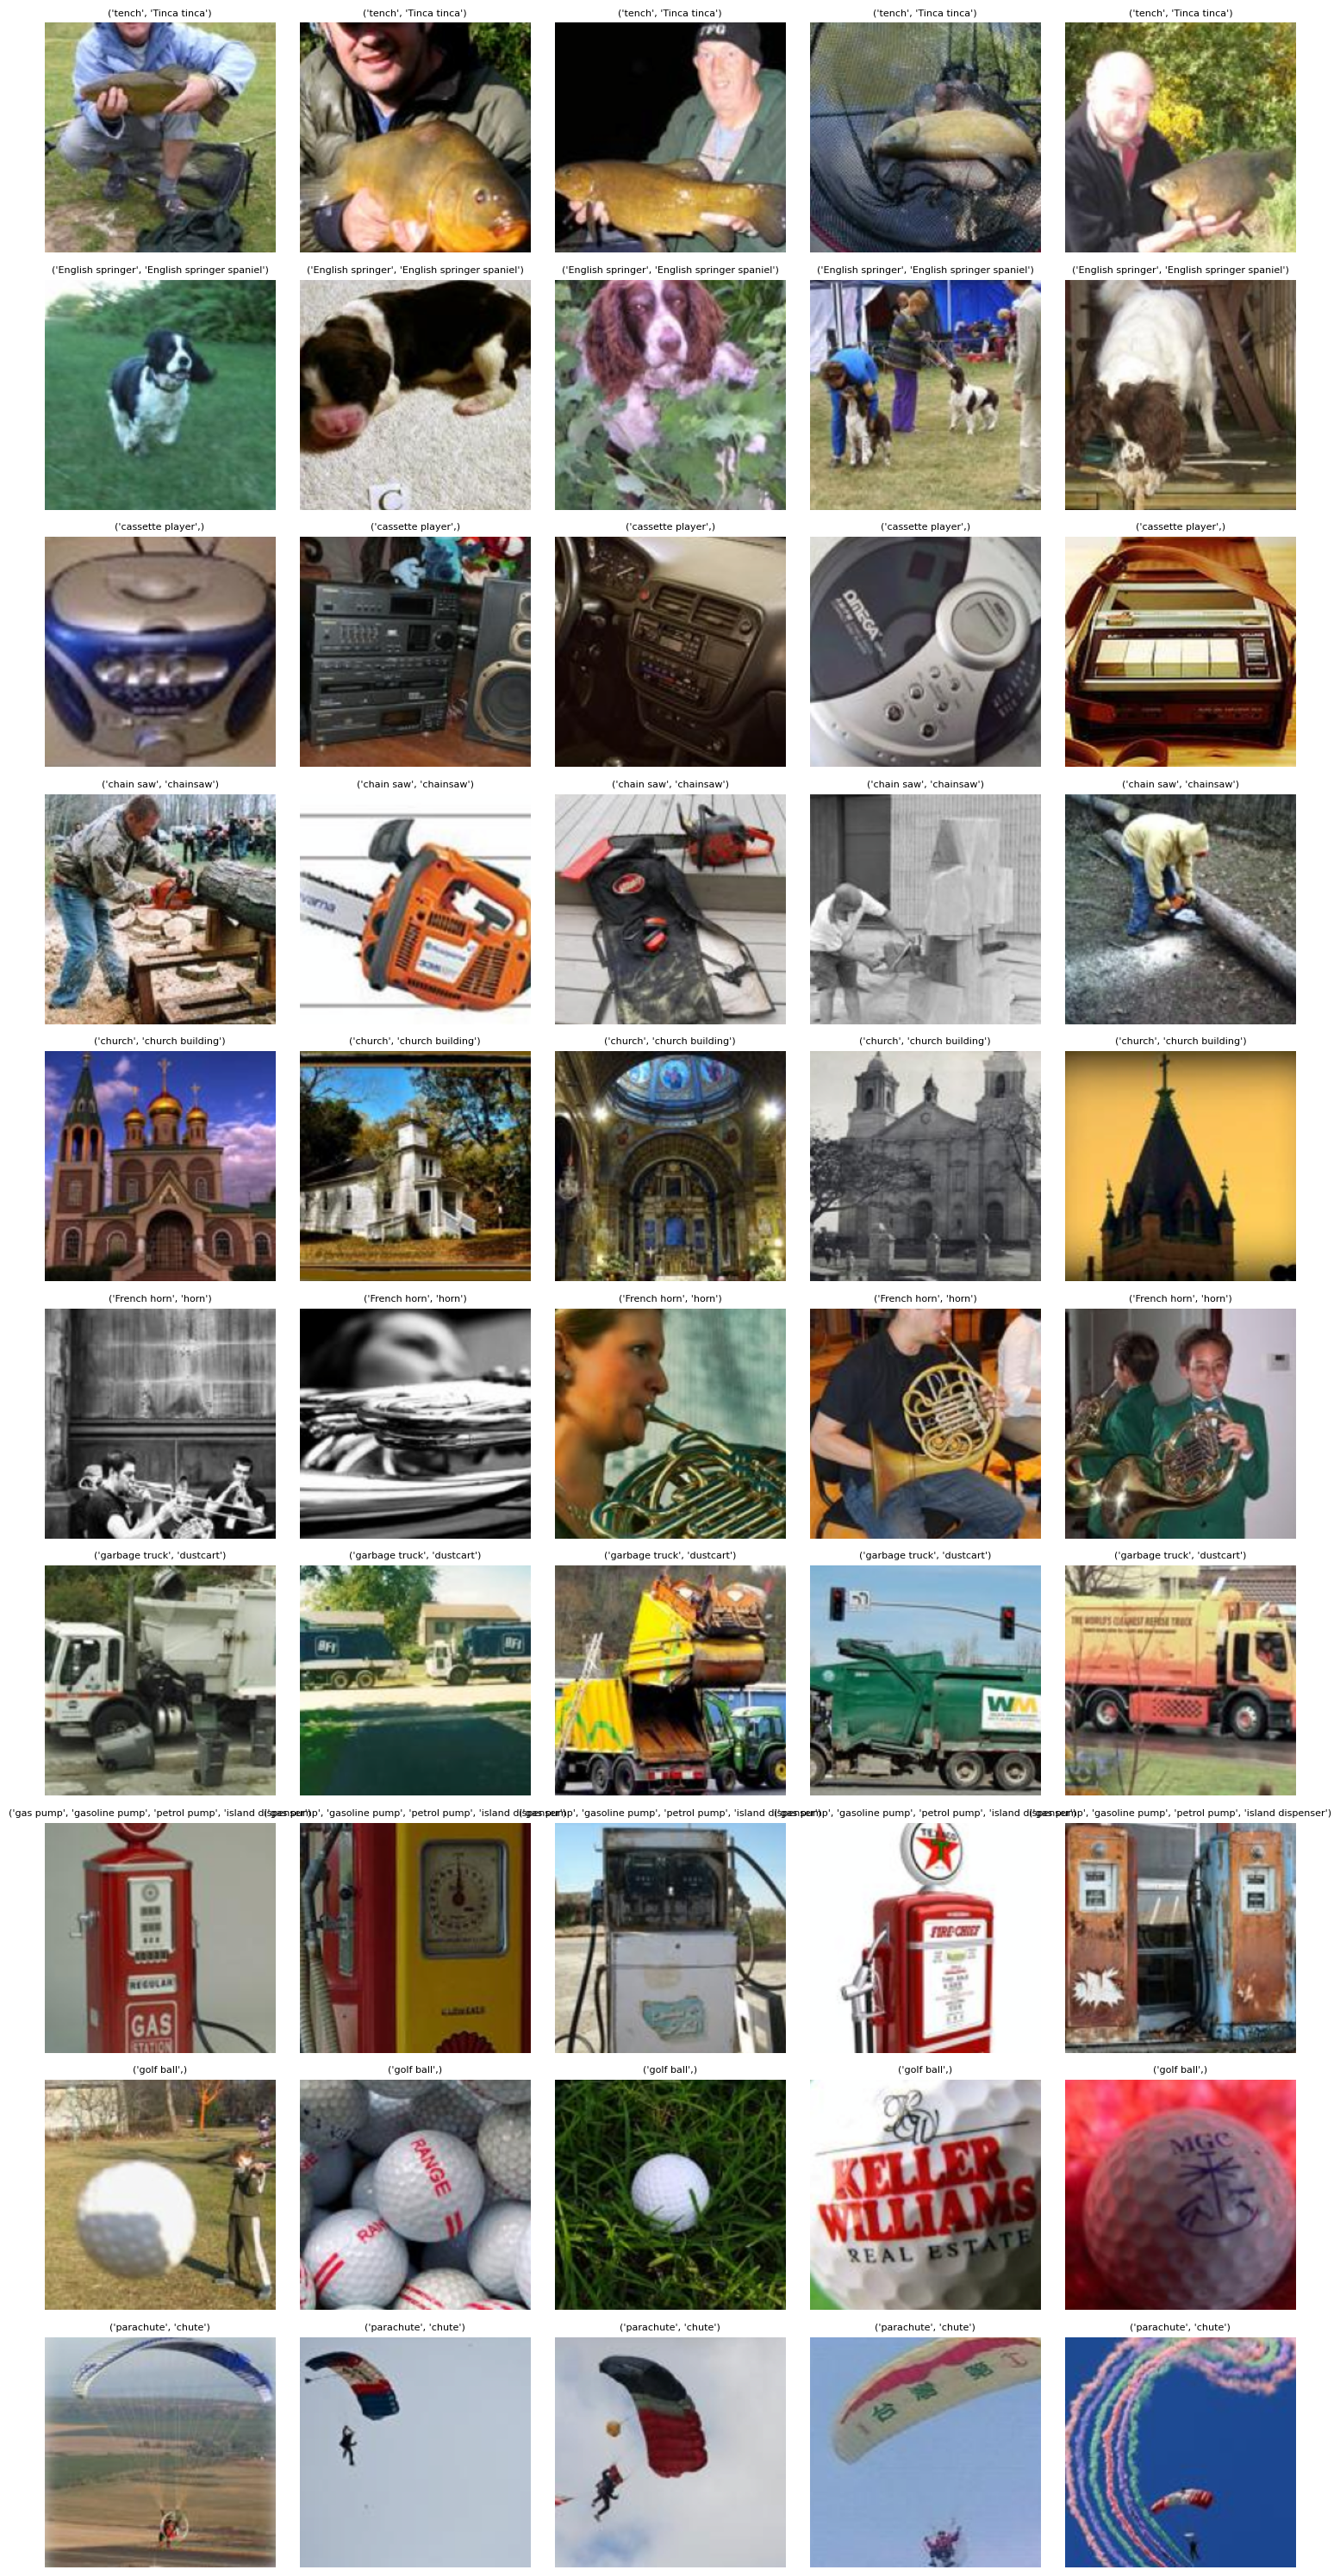

In [ ]:
# Plot 5 random samples from each class
rows, cols = len(class_names), 5
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

for class_label in range(len(class_names)):
    selected_indices = random.sample(class_image_indices[class_label], cols)

    for col, idx in enumerate(selected_indices):
        image, _ = Imagenette_data[idx]
        # Convert tensor image Imegenette_data to numpy array for visualization
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean  # Unnormalize
        image = np.clip(image, 0, 1)

        ax = axes[class_label, col]
        ax.imshow(image)
        ax.axis('off')

        # Add title to each image
        if col == 0:
            ax.set_ylabel(class_names[class_label], fontsize=10)
        ax.set_title(class_names[class_label], fontsize=8)

plt.tight_layout()
plt.show()

# EX2 - Pretrained models (20pts)

1. Choose 2 models from ```torchvision.models``` ([link](https://pytorch.org/vision/stable/models.html)) that were pretrained on ImageNet. The third model is one of ResNet18/34/50 (the other models can't other ResNet variation).
2. Use ```torch-summary``` to summarize each model for an input of shape ```1x3x224x224```.
3. Describe each model in 2-4 lines. Think carefully what information might be relevant for this homework assignment (see EX3-EX4). It is recommended to read the paper in which each model was first presented but it is not required. You are, however, required to go over model's description in torchvision documentation (see the information tab for ResNet18 for an example [link](https://pytorch.org/vision/0.19/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) )
4. Summarize the similarities and difference between the 3 models.

In [ ]:
convnext_net = torchvision.models.convnext_tiny(pretrained=True).to('cuda')
print("summary of convnext net")
print(summary(convnext_net, (3, 224, 224)))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 118MB/s]


summary of convnext net
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNo

**The convNext net is a modernized convultional net, inspired by the hierarchical design of Transformers, aiming to achieve good performance while retaining the simplicity of CNNs. It uses big kernel sizes, depthwise convolutions, and Layer Normalization instead of Batch Normalization, we used the tiny version of this net that has very good accuracy levels, while the number of parameters ~29M is considered low.**

In [ ]:
swin_transformer = torchvision.models.swin_t(pretrained=True).to('cuda')
print("summary of swin transformer")
print(summary(swin_transformer, (3, 224, 224)))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 168MB/s]


summary of swin transformer
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
           Permute-2           [-1, 56, 56, 96]               0
         LayerNorm-3           [-1, 56, 56, 96]             192
         LayerNorm-4           [-1, 56, 56, 96]             192
ShiftedWindowAttention-5           [-1, 56, 56, 96]               0
   StochasticDepth-6           [-1, 56, 56, 96]               0
         LayerNorm-7           [-1, 56, 56, 96]             192
            Linear-8          [-1, 56, 56, 384]          37,248
              GELU-9          [-1, 56, 56, 384]               0
          Dropout-10          [-1, 56, 56, 384]               0
           Linear-11           [-1, 56, 56, 96]          36,960
          Dropout-12           [-1, 56, 56, 96]               0
  StochasticDepth-13           [-1, 56, 56, 96]               0
SwinTra

**The Swin Transformer is a transformer that adapts better to vision by introducing a hierarchical architecture with a Shifted Windowing scheme, The image is divided into fixed-size, non-overlapping windows then self attention is computed, then the window moves a few pixels enabling efficient self-attention computation in local windows while allowing cross-window connections. This design supports big scale feature representation with good computation time (linear in image pixels size). Swin Transformer achieves very good results for classification . The Swin-Tiny variant has ~28M parameters, balancing performance and efficiency.**

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to('cuda')
print("summary of resnet18")
print(summary(resnet18, (3, 224, 224)))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


summary of resnet18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-1

***ResNet18 is part of the ResNet family, introducing residual(skip) connections that solve the vanishing gradient problem. ResNet18 has 18 layers and is considered lightweight (~12M parameters), suitable for applications requiring faster inference. ***

# Comparison of the three models:

 **ResNet18 is the simplest and most efficient, ideal for lightweight tasks.
ConvNeXt-Tiny modernizes CNNs and is a strong middle ground between ResNet18 and Swin Transformer. both ResNet and ConvNext are CNNs.
Swin Transformer excels in modeling complex ,uses the attention mechanism and giving the best results of the three, but it is the most heavy computational wise model. They are all giving good results(~90-95 percent) for a top5 prediction which later on can be seen using the knn algorithm, but the top1 prediction is clearly better for the swin transformer. (accuracy based on 1000 classes imagenet dataset).**

# EX3 - Visualizing feature maps (30pts)
In this section you will visualize the feature maps learned by your chosen models.


*   In a convoultion-based models (i.e., ResNet, ConvNext), use the final conv block. If the image resolution is too small do to maxpooling operations, you may choose a different block.
*   In a vision transformer (ViT), use model output without the cls token (if relevant).

Assignments:


1.   Describe the feature map shape for an input image of shape ```1x3x224x224``` (i.e., ```1x512xHxW``` for some model).
2. Choose 1 class from Imagenette and sample 10 random images.
3. Extract the feature maps from each model and perform PCA on the channel dim from 512 to 3. The output should be of size ```10x3xHxW```
4. Resize the features to 112x112 and plot the images for each model (3 row x 10 columns)
5. Summarize the similarities and difference between the 3 models according to the PCA for the features you have presented.





In [ ]:
feature_maps_resnet = []
feature_maps_convnext = []
feature_maps_swin = []
resnet18 = resnet18.cpu()
resnet18.eval()
convnext_net = convnext_net.cpu()
convnext_net.eval()
swin_transformer = swin_transformer.cpu()
swin_transformer.eval()

def hook_fn_resnet(module, input, output):
    feature_maps_resnet.append(output.detach())

def hook_fn_convnext(module, input, output):
    feature_maps_convnext.append(output.detach())

def hook_fn_swin(module, input, output):
    feature_maps_swin.append(output.detach())


chosen_class_indices = [i for i, (_, label) in enumerate(Imagenette_data) if label == 0]
random_indices = random.sample(chosen_class_indices, 10)
random_samples = [Imagenette_data[idx][0] for idx in random_indices]

hook1 = resnet18.layer4.register_forward_hook(hook_fn_resnet)
hook2 = convnext_net.features[-1].register_forward_hook(hook_fn_convnext)
hook3 = swin_transformer.permute.register_forward_hook(hook_fn_swin)

_ = resnet18(torch.stack(random_samples))
resnet_feature_maps = feature_maps_resnet[0]
_ = convnext_net(torch.stack(random_samples))
convnext_feature_maps = feature_maps_convnext[0]
_ = swin_transformer(torch.stack(random_samples))
swin_feature_maps = feature_maps_swin[0]


print("ResNet18 Feature Map Shape: ", feature_maps_resnet[0][:1].shape)
print("ConvNeXt Feature Map Shape: ", feature_maps_convnext[0][:1].shape)
print("Swin Transformer Feature Map Shape: ", feature_maps_swin[0][:1].shape)

feature_maps_resnet.clear()
feature_maps_convnext.clear()
feature_maps_swin.clear()

hook1.remove()
hook2.remove()
hook3.remove()

ResNet18 Feature Map Shape:  torch.Size([1, 512, 7, 7])
ConvNeXt Feature Map Shape:  torch.Size([1, 768, 7, 7])
Swin Transformer Feature Map Shape:  torch.Size([1, 768, 7, 7])


In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

def perform_PCA(feature_maps, n_components=3):
    """
    Perform PCA on feature maps.
    Input:
        feature_maps [torch.Tensor]: Shape (b, c, h, w)
        n_components [int]: Number of principal components
    Output:
        reduced_features [torch.Tensor]: Shape (b, n_components, h, w)
    """
    # Convert feature maps to numpy and flatten spatial dimensions
    b, c, h, w = feature_maps.shape
    feature_maps_np = feature_maps.detach().cpu().numpy().reshape(b, c, h * w)  # Shape: (b, c, h*w)

    reduced_features = []

    for f in feature_maps_np:
        f = f.T  # Shape: (h*w, c)
        scaler = StandardScaler()
        f_standardized = scaler.fit_transform(f)
        covariance_matrix = np.cov(f_standardized, rowvar=False)

        eigenvalues, eigenvectors = eigh(covariance_matrix)
        top_indices = np.argsort(eigenvalues)[-n_components:][::-1]
        top_eigenvectors = eigenvectors[:, top_indices]  # Shape: (c, n_components)

        # Project the data
        f_reduced = np.matmul(f_standardized, top_eigenvectors)
        # Reshape back to spatial dimensions
        f_reduced = f_reduced.T.reshape(n_components, h, w)  # Shape: (n_components, h, w)
        reduced_features.append(f_reduced)

    reduced_features = np.stack(reduced_features, axis=0)  # Shape: (b, n_components, h, w)
    return torch.tensor(reduced_features, dtype=torch.float32)


resnet_pca = perform_PCA(resnet_feature_maps)
convnext_pca = perform_PCA(convnext_feature_maps)
swin_pca = perform_PCA(swin_feature_maps)

print("ResNet PCA shape:", resnet_pca.shape)
print("ConvNeXt PCA shape:", convnext_pca.shape)
print("Swin PCA shape:", swin_pca.shape)




ResNet PCA shape: torch.Size([10, 3, 7, 7])
ConvNeXt PCA shape: torch.Size([10, 3, 7, 7])
Swin PCA shape: torch.Size([10, 3, 7, 7])


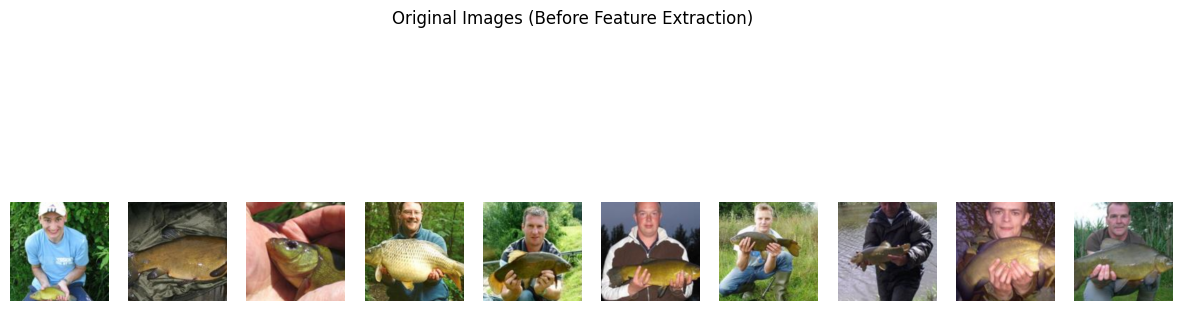

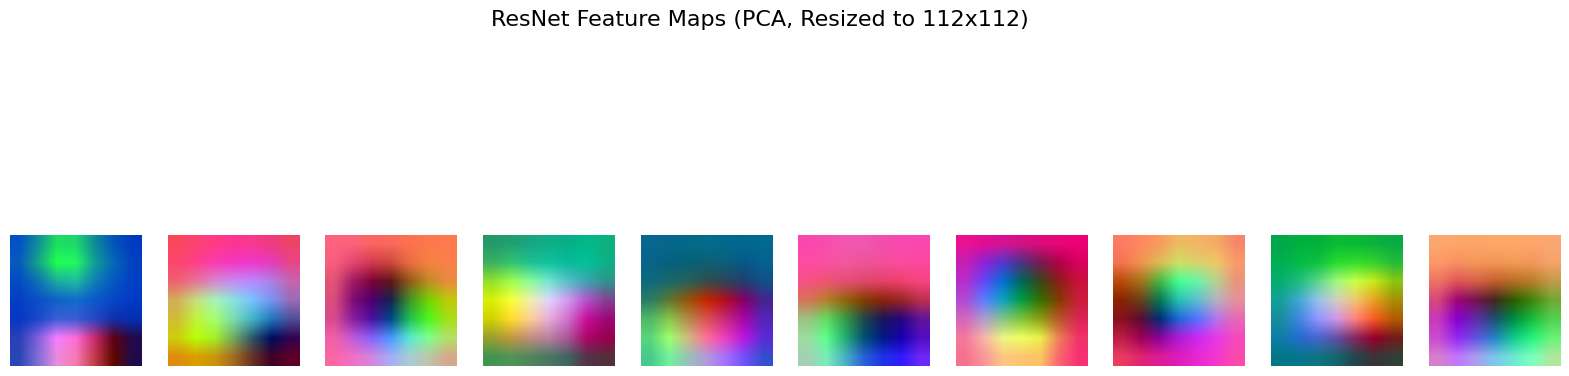

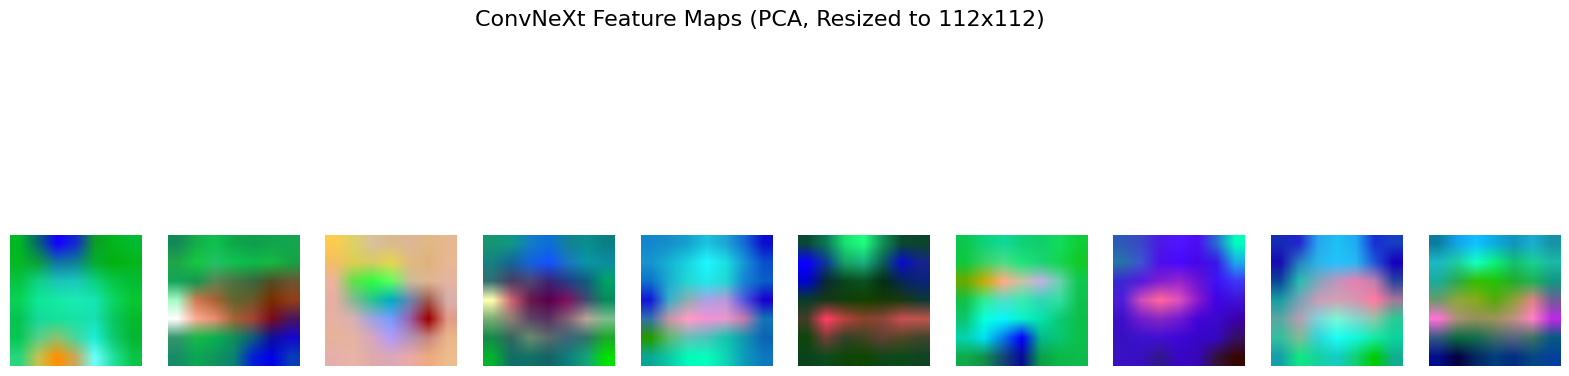

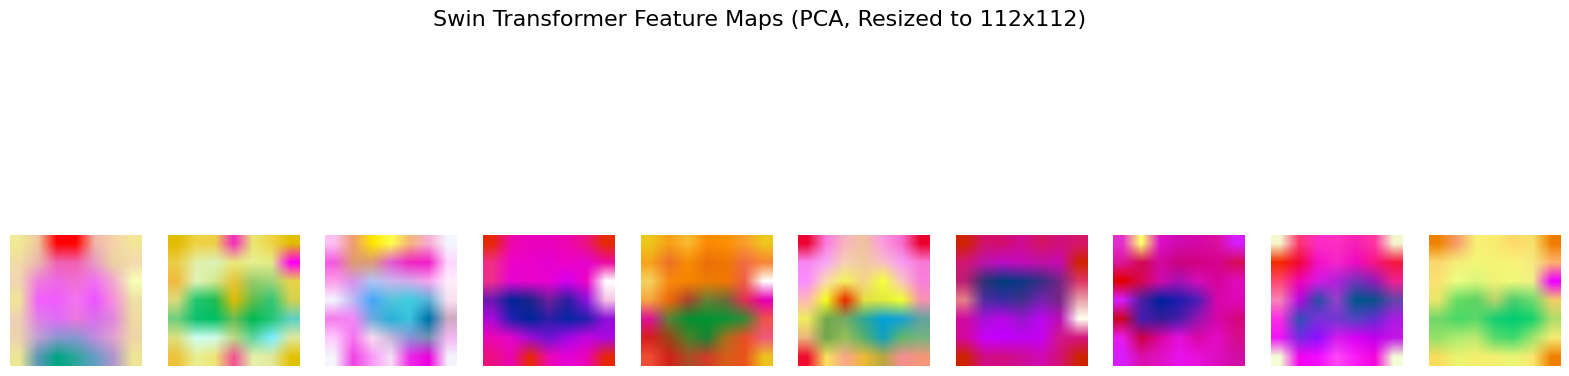

In [ ]:
import torch.nn.functional as F
import torchvision.transforms as T

# Denormalize function for visualization
def denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Denormalize an image from normalized [0, 1] range to its original range."""
    image = image.clone()
    channels = len(mean)
    for c in range(channels):  # Loop through each channel
        image[c] = image[c] * std[c] + mean[c]  # Apply standard deviation and mean
    return image.clamp(0, 1)  # Clamp values to [0, 1]

# Denormalize and plot images
def plot_original_images(images, title="Original Images"):
    """Plot original images before feature extraction."""
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        img = denormalize(img).permute(1, 2, 0).numpy()  # Denormalize and convert to HxWxC
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Visualize the 10 random samples
plot_original_images(random_samples, title="Original Images (Before Feature Extraction)")
def resize_features(features, target_size=(112, 112)):
    """Resize feature maps to the target size using bilinear interpolation."""
    return F.interpolate(features, size=target_size, mode='bilinear', align_corners=False)

def normalize(features):
    """Normalize feature maps to [0, 1] for visualization."""
    features = features - features.min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0]
    features = features / (features.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0] + 1e-5)  # Avoid division by zero
    return features

def plot_feature_maps(features, title, num_images=10):
    """Plot feature maps in a 3-row × 10-column grid."""
    features = features[:num_images].detach().cpu().numpy()  # Convert to NumPy
    fig, axes = plt.subplots(1, 10, figsize=(20, 6))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = np.transpose(features[i], (1, 2, 0))  # Convert to (H, W, 3)
            ax.imshow(img)
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

# Resize the PCA-transformed feature maps
resnet_resized = resize_features(resnet_pca)  # Shape (10, 3, 112, 112)
convnext_resized = resize_features(convnext_pca)  # Shape (10, 3, 112, 112)
swin_resized = resize_features(swin_pca)  # Shape (10, 3, 112, 112)

# Normalize
resnet_resized = normalize(resnet_resized)
convnext_resized = normalize(convnext_resized)
swin_resized = normalize(swin_resized)

# Plot
plot_feature_maps(resnet_resized, "ResNet Feature Maps (PCA, Resized to 112x112)")
plot_feature_maps(convnext_resized, "ConvNeXt Feature Maps (PCA, Resized to 112x112)")
plot_feature_maps(swin_resized, "Swin Transformer Feature Maps (PCA, Resized to 112x112)")




# Similarities:
 1. **Key Region Focus:** All models focus on important areas that help with classification.

2. **Hierarchical Features:** Each model detects patterns like edges and textures, capturing different levels of detail.

# Differences:
 1. **Resolution & Detail:** ResNet creates blurry and repetitive feature maps, while ConvNeXt and Swin Transformer capture finer details.

2. **Feature Clarity:** ResNet’s learned features look scattered and unclear, ConvNeXt produces sharper and more structured features, and Swin Transformer captures the most complete patterns.

3. **Shape vs. Texture:** ResNet struggles to separate shapes clearly, ConvNeXt outlines objects well, and Swin Transformer focuses on overall structure with rich textures.

4. **Color & Separation:** ResNet’s feature maps look blurry and less varied, ConvNeXt keeps features well-organized, and Swin Transformer shows clear boundaries with strong contrast.

5. **Final Insight:** Swin Transformer captures the most detailed and structured features, while ResNet has weaker clarity and separation.

# EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50pts)
Also know ans "few-shot/ Zero-shot learning".
Perform KNN classification using the feature vectors from each of the 3 models between the train and test set of Imagenette.


## Visualizing the embedding layer distribution.
* Write an ```extract_embedding(dataloader, model, model_name)``` function that takes in a dataloader and a model and return the ```N x Num_features``` matrix for that set. Make sure that shuffle is off.
* You may write different condition for different models. I.e., the embedding in a ViT model is the ```CLS``` token.

* Plot the t-SNE of the train set for each of the 3 models. Color label the points according to the class labels (see t-SNE implementation by sklearn).

* Write a 2-3 lines disscussion about the data distribution of each model and their comparison.


## Build a KNN ```class``` with the following methods:


*   ```init()```: takes the num_classes and other useful information.
* ```extract_embedding(X, model)```: Extracts the embedding vector for the entire train set using the model. X_features should be ```Nxnum_ft```. Call the function from the previous section.

*   ```fit(X_train, model)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and stores it as ```self.X_train_ft``` and ```self.y_labels``` (the labels from the train set).  


*   ```predict(X_test, model, n_neighbors)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and performs KNN for a given K. Returns the predicted_labels.
* ```compute_accuracy(y_true, y_pred)```.


## Compare the KNN accuracy
using each of the 3 models for $K\in[1,3,5 ]$ and report the results in a table or a graph. Summarize the results in 2-4 lines.


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


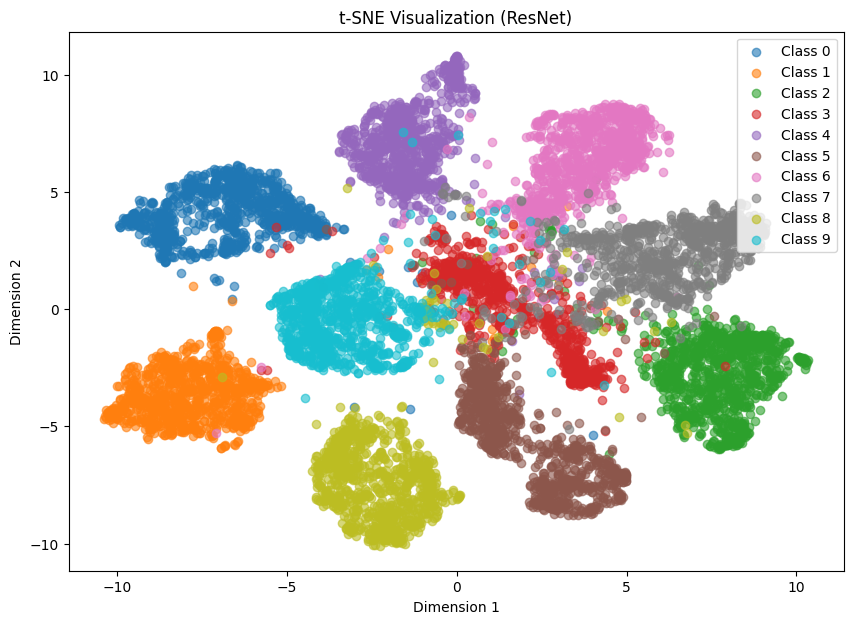

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


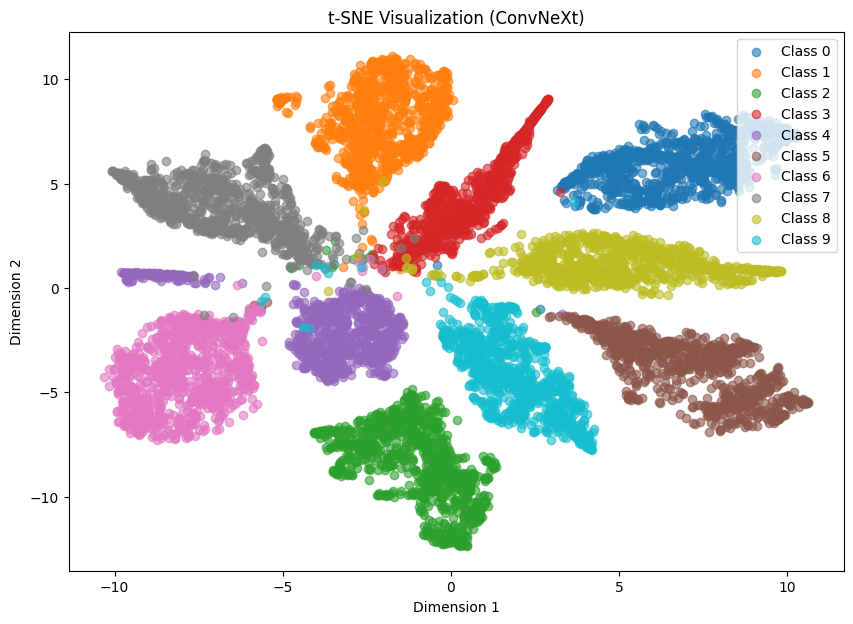

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


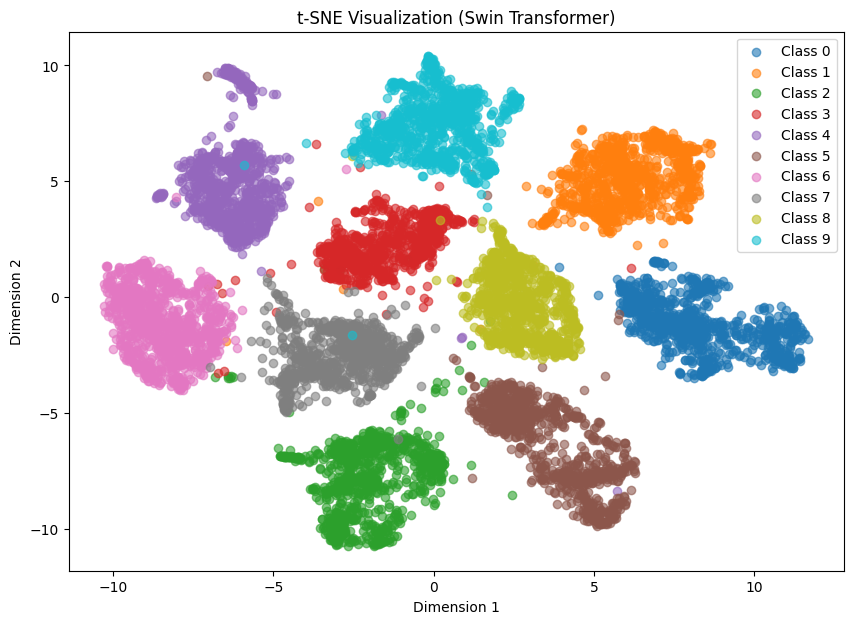

In [ ]:
def extract_embeddings(dataloader, model, model_name, device):
    """Extract embeddings for ResNet, ConvNeXt, or Swin Transformer."""
    feature_maps = []

    # Define hook function
    def hook_fn(module, input, output):
        feature_maps.append(output.detach())

    # Register hook on the appropriate layer based on the model type
    if model_name.lower() == "resnet":
        hook = model.avgpool.register_forward_hook(hook_fn)
    elif model_name.lower() == "convnext":
        hook = model.avgpool.register_forward_hook(hook_fn)
    elif model_name.lower() == "swin":
        hook = model.avgpool.register_forward_hook(hook_fn)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Ensure model is in evaluation mode
    model = model.to(device)
    model.eval()

    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            # Forward pass
            _ = model(images)

            # Process feature map
            feature_map = feature_maps[0]
            feature_map = feature_map.view(feature_map.size(0), -1)  # Flatten
            embeddings.append(feature_map.cpu())
            labels.append(targets.cpu())

            # Clear the feature maps after processing the batch
            feature_maps.clear()

    # Concatenate all embeddings and labels
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)

    # Remove the hook
    hook.remove()

    return embeddings, labels


def plot_tsne(embeddings, labels, model_name):
    """Plot t-SNE for the extracted embeddings."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    for class_label in np.unique(labels):
        idx = labels == class_label
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f"Class {class_label}", alpha=0.6)

    plt.title(f"t-SNE Visualization ({model_name})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()


# Example Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imagenette_dataloader = torch.utils.data.DataLoader(Imagenette_data)

# ResNet
embeddings_resnet, labels_resnet = extract_embeddings(
    imagenette_dataloader, resnet18, "resnet", device
)
plot_tsne(embeddings_resnet.cpu().numpy(), labels_resnet.cpu().numpy(), "ResNet")

# ConvNeXt
embeddings_convnext, labels_convnext = extract_embeddings(
    imagenette_dataloader, convnext_net, "convnext", device
)
plot_tsne(embeddings_convnext.cpu().numpy(), labels_convnext.cpu().numpy(), "ConvNeXt")

# Swin Transformer
embeddings_swin, labels_swin = extract_embeddings(
    imagenette_dataloader, swin_transformer, "swin", device
)
plot_tsne(embeddings_swin.cpu().numpy(), labels_swin.cpu().numpy(), "Swin Transformer")


# Comparison of t-SNE Embeddings:
**ResNet:**
Shows moderate class separation but with noticeable gaps and overlaps. Embeddings are less compact, leading to regions of uncertainty and misclassification. Some class collisions indicate difficulties in distinguishing between similar categories.

**ConvNeXt:**
Displays more compact and well-separated clusters compared to ResNet. Features are better aligned, leading to clearer class boundaries and fewer overlaps. Stronger feature discrimination improves classification accuracy.

**Swin Transformer:**
Exhibits the most distinct and well-defined clusters. Minimal class collisions, suggesting highly discriminative feature learning. Likely benefits from attention mechanisms, providing robust feature representations.

**Conclusion:**
While ResNet achieves reasonable separation, ConvNeXt improves clustering, and Swin Transformer delivers the best feature discrimination with clear class boundaries.



In [ ]:
class KNN_CLF:
    def __init__(self, num_classes, model, model_name):
        self.num_classes = num_classes
        self.X_train_ft = None
        self.y_labels = None
        self.model = model
        self.model_name = model_name
        self.distances = None  # To store the precomputed distances

    def fit(self, dataloader, device):
        embeddings, labels = extract_embeddings(dataloader, self.model, self.model_name, device)
        self.X_train_ft = embeddings
        self.y_labels = labels

    def compute_distances(self, test_embeddings, device):
        # Compute L2 distances once, reuse for different k values
        test_embeddings = torch.tensor(test_embeddings, device=device).clone().detach()
        train_embeddings = torch.tensor(self.X_train_ft, device=device).clone().detach()
        distances = torch.cdist(test_embeddings, train_embeddings, p=2)  # L2 distance
        return distances

    def predict(self, dataloader, device, k_values):
        test_embeddings, test_labels = extract_embeddings(dataloader, self.model, self.model_name, device)

        # Compute distances once
        distances = self.compute_distances(test_embeddings, device)

        preds = []
        for k in k_values:
            # Get the indices of the n_neighbors nearest neighbors for each test sample
            _, nearest_indices = torch.topk(distances, k, largest=False, sorted=False)

            # Get the labels of the nearest neighbors
            nearest_indices = nearest_indices.cpu()
            nearest_labels = self.y_labels[nearest_indices]  # Shape: (num_test_samples, n_neighbors)

            # Perform majority vote to get the predicted labels
            majority_vote = torch.mode(nearest_labels, dim=1).values
            preds.append(majority_vote)

        # Return predictions for all k values
        return np.array(test_labels), [p.cpu().numpy() for p in preds]

    def compute_accuracy(self, y_true, y_pred):
        # Compute accuracy
        return np.mean(y_true == y_pred)


In [ ]:
def evaluate_knn(models, train_loader, val_loader, device, k_values):
    results = []

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        knn_classifier = KNN_CLF(num_classes=len(classes), model=model, model_name=model_name)

        # Fit on train embeddings
        knn_classifier.fit(train_loader, device)

        # Predict on test embeddings for all k values
        y_true, y_pred = knn_classifier.predict(val_loader, device, k_values)

        for k, pred in zip(k_values, y_pred):
            # Compute accuracy
            accuracy = knn_classifier.compute_accuracy(y_true, pred)
            results.append({"Model": model_name, "K": k, "Accuracy": accuracy})
            print(f"K={k}, Accuracy={accuracy:.4f}")

    return results



Evaluating resnet...


<ipython-input-48-c3e0442df3d4>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.tensor(test_embeddings, device=device).clone().detach()
<ipython-input-48-c3e0442df3d4>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.tensor(self.X_train_ft, device=device).clone().detach()


K=1, Accuracy=0.9534
K=3, Accuracy=0.9562
K=5, Accuracy=0.9620

Evaluating convnext...
K=1, Accuracy=0.9893
K=3, Accuracy=0.9913
K=5, Accuracy=0.9924

Evaluating swin...
K=1, Accuracy=0.9898
K=3, Accuracy=0.9908
K=5, Accuracy=0.9916


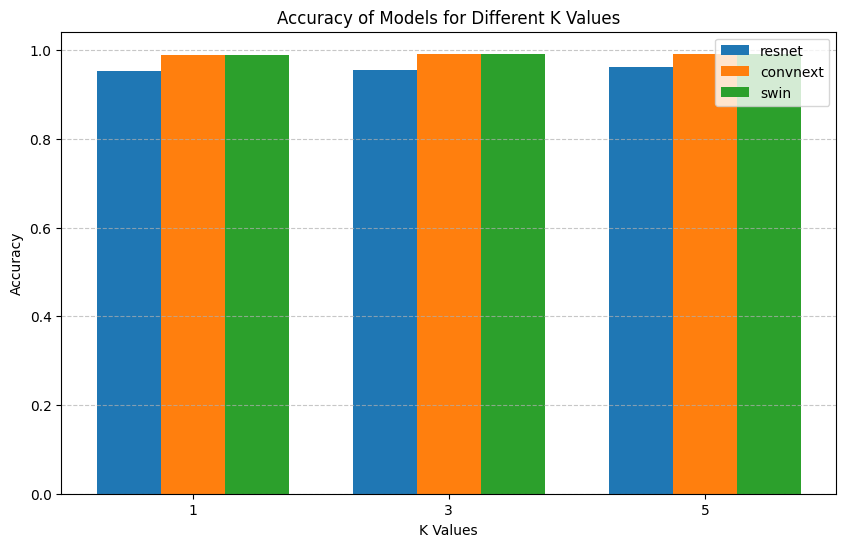

In [ ]:
from torch.utils.data import DataLoader, Subset

# Prepare data loaders without shuffling
train_loader = DataLoader(Imagenette_data_train, batch_size=32, shuffle=False)
val_loader = DataLoader(Imagenette_data_val, batch_size=32, shuffle=False)

models = {
    'resnet': resnet18,
    'convnext': convnext_net,
    'swin': swin_transformer
}
k_values = [1, 3, 5]

# Initialize results storage
results = evaluate_knn(models, train_loader, val_loader, device, k_values)

# Store accuracies
accuracies = {model: [] for model in models}
for result in results:
    accuracies[result['Model']].append(result['Accuracy'])

# Plotting results
x = np.arange(len(k_values))  # Positions for k values
bar_width = 0.25

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    plt.bar(x + i * bar_width, accuracies[model], width=bar_width, label=model)

# Labels and legends
plt.xticks(x + bar_width, k_values)
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models for Different K Values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


**The results show that ConvNeXT and Swin perform better than ResNet for all K values. ResNet has the lowest accuracy, reaching a maximum of 0.9620, while both ConvNeXT and Swin go above 0.99. Swin is slightly better than ConvNeXT, but the difference is very small. This suggests that ConvNeXT and Swin are better at learning useful features compared to ResNet. Also, accuracy improves a little as K increases, showing that using more neighbors in K-NN helps make better predictions.**